In [2]:
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install plotly




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Import libraries**

In [37]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.tsa.stattools as ts


# 1. Concept

## Idea
What are our signals, why this industry, why this stocks...
## Pair Strategy
Add description of our strategy.


# 2. Data

# Retrive data

For each stock we get data from Yahoo Finance based on tickers provided in a list.

## Stock pick

We choose energy sector stocks from *S&P 500* as it is known that they have been highly correlated in the past. We picked 10 stocks with highest market cap in this sector. 

**STOCK LIST:**
- Exxon Mobil Corporation [XOM]
- Chevron Corporation [CVX]
- ConocoPhillips [COP]
- Schlumberger Limited [SLB]
- EOG Resources, Inc. [EOG]
- Marathon Petroleum Corporation [MPC]
- Phillips 66 [PSX]
- Enterprise Products Partners L.P. [EPD]
- Pioneer Natural Resources Company [PXD]
- Occidental Petroleum Corporation [OXY]




## Hourly data
We get data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [4]:
# Companies tickers list
ticker_list=['XOM', 'CVX', 'COP' , 'SLB', 'EOG','MPC', 'PSX', 'EPD', 'PXD', 'OXY', '^GSPC']

#get data for last 730 days on hounrly time frame
df_hourly = yf.download(ticker_list, period="730d", interval="1h")['Adj Close']

#rename sp500
df_hourly = df_hourly.rename(columns={'^GSPC':'SP500'})


[*********************100%%**********************]  11 of 11 completed


In [5]:
#check info of our data frame
df_hourly.info()
print(20*'**'+ '\n')

#count NaN values in each column
nan_counts_hourly = df_hourly.isna().sum()
display(nan_counts_hourly)
print(20*'**'+ '\n')

#let's check the index. We want date as index
df_hourly.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5090 entries, 2021-04-08 09:30:00-04:00 to 2024-03-01 11:30:00-05:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     5090 non-null   float64
 1   CVX     5090 non-null   float64
 2   EOG     5068 non-null   float64
 3   EPD     5090 non-null   float64
 4   MPC     5090 non-null   float64
 5   OXY     5090 non-null   float64
 6   PSX     5090 non-null   float64
 7   PXD     5090 non-null   float64
 8   SLB     5020 non-null   float64
 9   XOM     5090 non-null   float64
 10  SP500   5090 non-null   float64
dtypes: float64(11)
memory usage: 477.2 KB
****************************************



Ticker
COP       0
CVX       0
EOG      22
EPD       0
MPC       0
OXY       0
PSX       0
PXD       0
SLB      70
XOM       0
SP500     0
dtype: int64

****************************************



DatetimeIndex(['2021-04-08 09:30:00-04:00', '2021-04-08 10:30:00-04:00',
               '2021-04-08 11:30:00-04:00', '2021-04-08 12:30:00-04:00',
               '2021-04-08 13:30:00-04:00', '2021-04-08 14:30:00-04:00',
               '2021-04-08 15:30:00-04:00', '2021-04-09 09:30:00-04:00',
               '2021-04-09 10:30:00-04:00', '2021-04-09 11:30:00-04:00',
               ...
               '2024-02-29 09:30:00-05:00', '2024-02-29 10:30:00-05:00',
               '2024-02-29 11:30:00-05:00', '2024-02-29 12:30:00-05:00',
               '2024-02-29 13:30:00-05:00', '2024-02-29 14:30:00-05:00',
               '2024-02-29 15:30:00-05:00', '2024-03-01 09:30:00-05:00',
               '2024-03-01 10:30:00-05:00', '2024-03-01 11:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=5090, freq=None)

For now, we keep data in `wide format`
- each stock is one column
- in all columns, the variable is the same: `adjusted close price`
- row index is date

In [6]:
# lets check what is maximum number of cosencutive NaN values
# If there is only a few we can decide to interpolate data with back ffill or bfill for example to get missing data

def max_consecutive_nan(column):
    max_consecutive = 0
    current_consecutive = 0

    for value in column:
        if pd.isna(value):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0

    return max_consecutive

# we apply function to each column 
max_nan_values = df_hourly.apply(max_consecutive_nan)
print(max_nan_values)

Ticker
COP      0
CVX      0
EOG      7
EPD      0
MPC      0
OXY      0
PSX      0
PXD      0
SLB      7
XOM      0
SP500    0
dtype: int64


Since there are ***max 7 consecutive NaN values*** we decide to interpolate data instead of dropping the whole series.

In [7]:
#fill missing data with last available data point before the sequence of NaN values
df_filled_hourly = df_hourly.ffill()

#we make sure there is no more missing values in each of our time series (DataFrame)
missing = df_filled_hourly.isna().sum().sum()
print(f'There are {missing} missing values in our DataFrame of hourly prices.')

There are 0 missing values in our DataFrame of hourly prices.


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [8]:
#remove datetime index for slicing needs
df_filled_hourly = df_filled_hourly.reset_index(drop=False)

In [9]:
#split data 70/30

length = len(df_filled_hourly)

#train data is 70% of all available data
df_train_hourly = df_filled_hourly.loc[:int(length*0.7)]
df_train_hourly.to_csv('data/pair_train_h.csv')

#test data is remaining 30% of data
df_test_hourly = df_filled_hourly.loc[int(length*0.7+1):]
df_test_hourly.to_csv('data/pair_test_h.csv')

In [10]:
#check if data is continous without dropped rows (check if index is correct)
display(df_train_hourly.tail(1))
display(df_test_hourly.head())


Ticker                  Datetime         COP         CVX      EOG      EPD  \
3563   2023-04-18 10:30:00-04:00  105.135002  171.160004  119.055  27.0338   

Ticker         MPC        OXY         PSX         PXD        SLB         XOM  \
3563    128.490005  62.639999  104.230003  227.221802  52.150002  115.449997   

Ticker        SP500  
3563    4146.910156

Ticker                  Datetime         COP         CVX         EOG  \
3564   2023-04-18 11:30:00-04:00  105.614998  172.070007  120.385002   
3565   2023-04-18 12:30:00-04:00  105.000000  171.330002  120.000000   
3566   2023-04-18 13:30:00-04:00  104.650002  170.824997  119.144997   
3567   2023-04-18 14:30:00-04:00  104.370003  170.574997  118.974297   
3568   2023-04-18 15:30:00-04:00  104.940002  170.520004  119.000000   

Ticker        EPD         MPC        OXY         PSX         PXD        SLB  \
3564    27.080000  129.639999  63.099998  104.730003  228.234695  52.639999   
3565    27.045000  129.139999  62.997002  104.635002  228.479996  52.535000   
3566    26.969999  128.610596  62.840000  103.949997  228.009995  52.165001   
3567    27.025000  128.600006  62.884998  104.099998  227.839996  52.091900   
3568    27.004999  129.039993  63.000000  104.320000  228.440002  52.150002   

Ticker         XOM        SP500  
3564    116.269997  4153.689941  
3565    116.709999  4148.930176  
3566    116.669998  4155.129883  
3567    116.894997  4153.029785  
3568    117.000000  4154.770020

# Daily data

In [11]:
# Set analyzed period
start_date="2000-01-01"
end_date="2023-12-31"

#get data from yahoo finance
df_daily = yf.download(ticker_list, start=start_date, end=end_date, interval="1d")['Adj Close']

#rename sp500
df_daily = df_daily.rename(columns={'^GSPC':'SP500'})

[*********************100%%**********************]  11 of 11 completed


In [12]:
#explore dataframe
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     6037 non-null   float64
 1   CVX     6037 non-null   float64
 2   EOG     6037 non-null   float64
 3   EPD     6037 non-null   float64
 4   MPC     3150 non-null   float64
 5   OXY     6037 non-null   float64
 6   PSX     2949 non-null   float64
 7   PXD     6037 non-null   float64
 8   SLB     6037 non-null   float64
 9   XOM     6037 non-null   float64
 10  SP500   6037 non-null   float64
dtypes: float64(11)
memory usage: 566.0 KB


In [13]:
# Count NaN values in each column
nan_counts = df_daily.isna().sum()

# Display the result
print(nan_counts)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [14]:
# we apply function to each column 
max_nan_values_daily = df_daily.apply(max_consecutive_nan)
print(max_nan_values_daily)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [15]:
#Drop columns of MPC and PSX

df_daily_filtered = df_daily.drop(columns=['MPC', 'PSX'])

#reset index
df_daily_filtered=df_daily_filtered.reset_index(drop=False)


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [16]:
#split data 70/30

length = len(df_daily_filtered)

#train data is 70% of all available data
df_train_daily = df_daily_filtered.loc[:int(length*0.7)]
df_train_daily.to_csv('data/pair_train_daily.csv')

#test data is remaining 30% of data
df_test_daily = df_daily_filtered.loc[int(length*0.7+1):]
df_test_daily.to_csv('data/pair_test_daily.csv')

# 3. EDA

## Hourly EDA

In [17]:
# load csv of train data
df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_h.set_index('Datetime', inplace=True)

df_train_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_32138/112882630.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)


COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-08 09:30:00-04:00  51.555000  102.695000  71.360001  22.650000   
2021-04-08 10:30:00-04:00  51.255001  102.709999  71.250000  22.600000   
2021-04-08 11:30:00-04:00  51.549999  102.875801  71.894997  22.735001   
2021-04-08 12:30:00-04:00  51.417198  102.769997  71.989998  22.740000   
2021-04-08 13:30:00-04:00  51.264999  102.730003  71.779999  22.770000   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-08 09:30:00-04:00  53.060001  24.415701  78.410004  149.970001   
2021-04-08 10:30:00-04:00  53.320000  24.525000  78.250000  148.779999   
2021-04-08 11:30:00-04:00  53.626999  24.750000  78.820000  150.169998   
2021-04-08 12:30:00-04:00  53.529999  24.655001  78.695000  149.589996   
2021-04-08 13:30:00-04:00  53.285000  24.610001  78.400002  149.130005   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-08 09:30:00-04:00  26.528400  55.860001  4087.199951  
2021-04-08 10:30:00-04:00  26.860001  55.730000  4091.419922  
2021-04-08 11:30:00-04:00  26.971001  55.959999  4094.570068  
2021-04-08 12:30:00-04:00  27.000000  55.863300  4093.939941  
2021-04-08 13:30:00-04:00  26.950001  55.855701  4096.129883

In [18]:
fig = px.line(df_train_h, x=df_train_h.index, y=df_train_h.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig.update_layout(title='Adjusted Hourly Close Prices of Selected Stocks And S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

#show plot
fig.show()

In [19]:
#make long format for pct_change calculation
df_long_h = pd.melt(df_train_h.reset_index(), id_vars=['Datetime'], var_name='ticker', value_name='price')

#set index again
df_long_h.set_index('Datetime', inplace=True)

#calculate pct change for each ticker
df_long_h['ret'] = df_long_h.groupby('ticker')['price'].pct_change()
df_long_h.dropna(inplace=True)


In [20]:
#calculate cumulative return
#df_long_h = df_long_h.sort_values(['Datetime', 'ticker'])
df_long_h['cum_ret'] = df_long_h.groupby('ticker')['ret'].transform(lambda x: np.cumprod(1 + x))

In [21]:
# Assuming df_long_h is your DataFrame with 'Datetime', 'ticker', and 'cumulative_return' columns
fig = px.line(df_long_h, x=df_long_h.index, y='cum_ret', color='ticker',
              title='Cumulative Returns of Selected Stocks',
              labels={'cum_ret': 'Cumulative Return', 'ticker': 'Ticker'},
              line_shape='linear')

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


### Correlation test

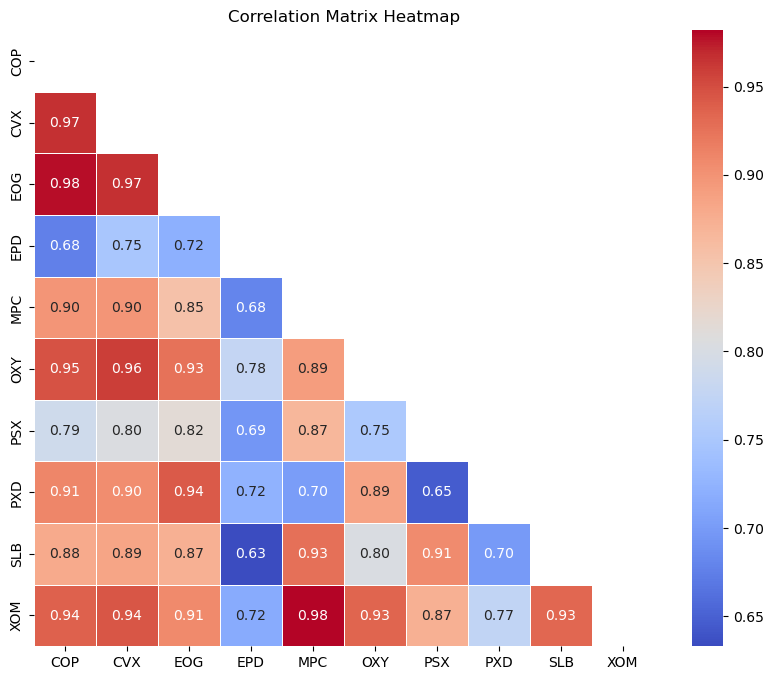

Top 5 Pairs Based on Cointegration Score:
         pair  Correlation score
0  (XOM, MPC)           0.981866
1  (EOG, COP)           0.978091
2  (CVX, COP)           0.966727
3  (EOG, CVX)           0.966288
4  (OXY, CVX)           0.959126


In [116]:
#drop SP500 column for statistical tests
df_train_h_stat = df_train_h.drop(columns='SP500')

corr_matrix_hourly = df_train_h_stat.corr()

#exclude diagonal and upper triangle
np.fill_diagonal(corr_matrix_hourly.values, np.nan)
mask = np.triu(np.ones_like(corr_matrix_hourly, dtype=bool))
corr_matrix_hourly = corr_matrix_hourly.mask(mask)

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_h = (corr_matrix_hourly.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_h['pair'] = top_pairs_cor_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Cointegration Score:")
print(top_pairs_cor_h[['pair', 'Correlation score']])




### Cointegration test
We are using augmented Engle-Granger two-step cointegration test.
Testing for cointegration. We want as low p-value as possible. Ideally < 2 %.

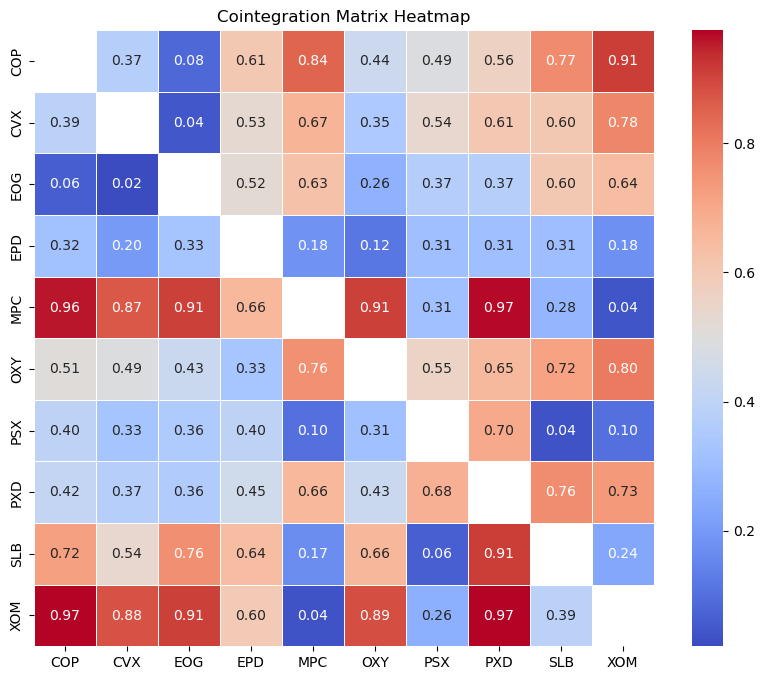

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EOG, CVX)  0.021241
1  (XOM, MPC)  0.037376
2  (PSX, SLB)  0.037909


In [109]:
columns = df_train_h_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_hourly = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_h_stat[col1], df_train_h_stat[col2])
            coint_matrix_hourly.loc[col1, col2] = p

#transform to numeric 
coint_matrix_hourly = coint_matrix_hourly.apply(pd.to_numeric, errors='coerce')


# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_h = (coint_matrix_hourly.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_h['pair'] = top_pairs_coint_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_h[['pair', 'P-value']])


After comparing correlation and cointegration pair (PSX,SLB) was drop due to lowest (0.91) correlation out of those three pairs. The pair we find in both lists of top cointegrated and correlated is **(XOM,MPC)**.

In [117]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_h['pair'])
pairs_df2 = set(top_pairs_coint_h['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('EOG', 'CVX')
('XOM', 'MPC')


### Stationarity - Augmented Dickey Fuller test

In [155]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = round(ts.adfuller(X)[1], 2)
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [156]:
#check for stationarity in our stocks
for ticker in df_train_h_stat.columns:
    stationarity_test(df_train_h_stat[ticker])

p-value = 0.49 The series COP is likely non-stationary.
p-value = 0.68 The series CVX is likely non-stationary.
p-value = 0.39 The series EOG is likely non-stationary.
p-value = 0.22 The series EPD is likely non-stationary.
p-value = 0.86 The series MPC is likely non-stationary.
p-value = 0.63 The series OXY is likely non-stationary.
p-value = 0.32 The series PSX is likely non-stationary.
p-value = 0.36 The series PXD is likely non-stationary.
p-value = 0.56 The series SLB is likely non-stationary.
p-value = 0.84 The series XOM is likely non-stationary.


Our results for stationarity are not the best, but the explenation is that our time horizon is more then 3 years and stocks rose in that time. Since our trades will be short term because of hourly time frame this is not so important and moreover we will be doing pair trading which means that pair's ratio needs to be stationary. So let's check for stationarity in our selected pair's ratio.

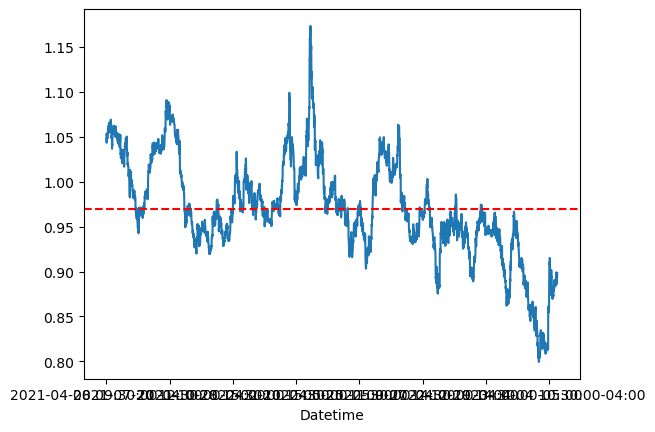

In [188]:
ticker1 = 'XOM'
ticker2 = 'MPC'

#calculate ratio
ratio_h = df_train_h_stat[ticker1]/df_train_h_stat[ticker2]
ratio_h = pd.Series(ratio_h, name='Ratio XOM/MPC')

#plot ratio adn mean
fig = ratio_h.plot(linestyle='-')
fig.axhline(ratio_h.mean(), color='red', linestyle='--', label='Mean')


In [189]:
stationarity_test(ratio_h)

p-value = 0.05 The series Ratio XOM/MPC is likely non-stationary.


We cannot say that the ratio of XOM/MPC is stationary process with a 2 % significance level but we can say so for a 5 % significance so we decide to proceed with this pair since all tests were quite tempting. 


## Daily EDA

In [133]:
# load csv of train data
df_train_d = pd.read_csv('data/pair_train_daily.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_d.set_index('Date', inplace=True)

df_train_d.head()


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_11067/506303630.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP        CVX       EOG       EPD       OXY       PXD  \
Date                                                                      
2000-01-03  7.988743  17.139816  2.775415  0.937857  5.084859  6.370454   
2000-01-04  7.834474  17.139816  2.775415  0.956998  4.977971  6.464832   
2000-01-05  7.691231  17.447252  2.697077  0.969758  5.008514  6.276078   
2000-01-06  7.955686  18.190231  2.920900  0.956998  5.145942  6.417643   
2000-01-07  7.955686  18.510483  2.887327  0.941048  5.298640  6.606398   

                  SLB        XOM        SP500  
Date                                           
2000-01-03  17.465258  18.328690  1455.219971  
2000-01-04  17.226831  17.977634  1399.420044  
2000-01-05  17.187080  18.957699  1402.109985  
2000-01-06  18.359381  19.937761  1403.449951  
2000-01-07  18.697163  19.879242  1441.469971

In [134]:
fig1 = px.line(df_train_d, x=df_train_d.index, y=df_train_d.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig1.update_layout(title='Adjusted Daily Close Prices of Selected Stocks and S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show the interactive plot
fig1.show()

### Correlation test

In [135]:
#make a copy of dataframe without column SP500 for statistical tests
df_train_d_stat = df_train_d.drop(columns='SP500')

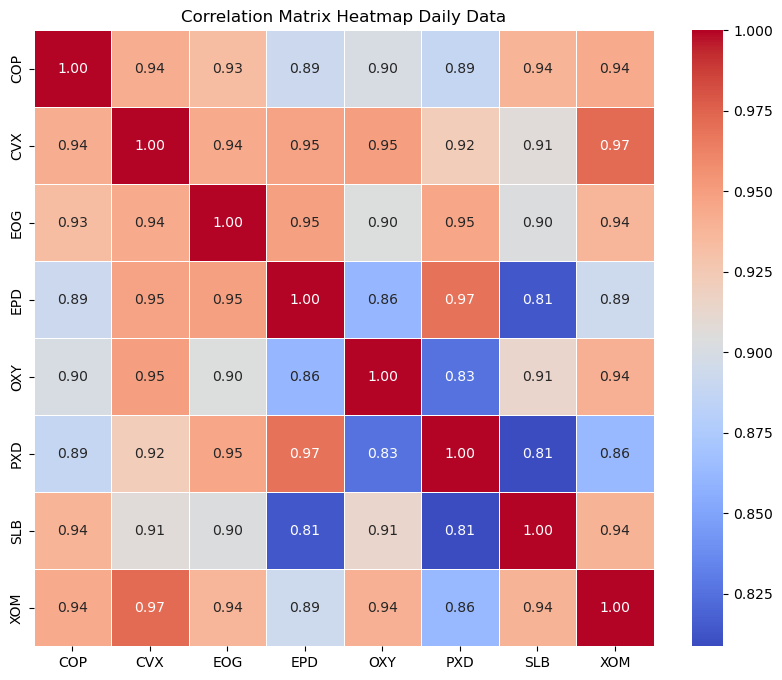

In [136]:
corr_matrix_daily = df_train_d_stat.corr()

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap Daily Data')
plt.show()

### Cointegration test

# 4. Strategy

## Standardization: Z-score

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i} = \frac{x_{i} - \bar{x}}{s}$$

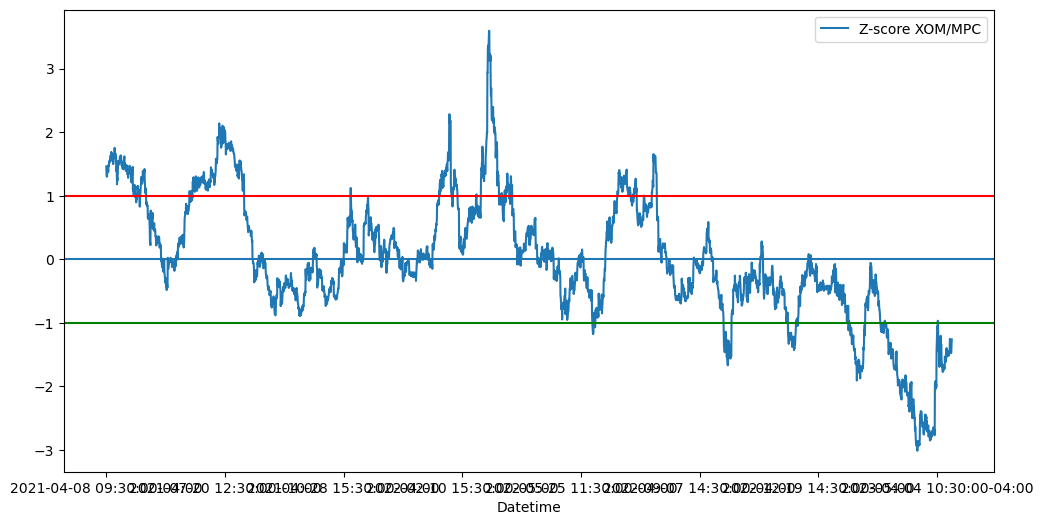

In [196]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore_h = zscore(ratio_h)
zscore_h.name = 'Z-score XOM/MPC'


zscore_h.plot(figsize=(12,6))
plt.axhline(zscore_h.mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.legend()

plt.show()